# ECG Foundation Model

__Date created:__ 2024/07/25 

__Last Modified:__ 2024/08/14 

__Description:__ Train, evaluate, and export an ECG foundation model

## Overview 

This notebook demonstrates creating a foundation model for raw ECG signals. By creating a foundation model, we can create small, down-stream classification models.

<!-- This should be added to the overrides/main.html and improved-->
<div class="grid cards" markdown>

- <svg xmlns="http://www.w3.org/2000/svg" height="50" width="50" viewBox="0 0 488 512"><!--!Font Awesome Free 6.6.0 by @fontawesome - https://fontawesome.com License - https://fontawesome.com/license/free Copyright 2024 Fonticons, Inc.--><path fill="#2094F3" d="M488 261.8C488 403.3 391.1 504 248 504 110.8 504 0 393.2 0 256S110.8 8 248 8c66.8 0 123 24.5 166.3 64.9l-67.5 64.9C258.5 52.6 94.3 116.6 94.3 256c0 86.5 69.1 156.6 153.7 156.6 98.2 0 135-70.4 140.8-106.9H248v-85.3h236.1c2.3 12.7 3.9 24.9 3.9 41.4z"/></svg>
<a href="https://colab.research.google.com/github/AmbiqAI/heartkit/blob/canary/docs/guides/train-arrhythmia-model.ipynb" class="md-content__button md-icon" style="color: #2094F3;">
    View in Colab
</a>

- <svg xmlns="http://www.w3.org/2000/svg" height="50" width="50" viewBox="0 0 496 512"><!--!Font Awesome Free 6.6.0 by @fontawesome - https://fontawesome.com License - https://fontawesome.com/license/free Copyright 2024 Fonticons, Inc.--><path fill="#2094F3" d="M165.9 397.4c0 2-2.3 3.6-5.2 3.6-3.3 .3-5.6-1.3-5.6-3.6 0-2 2.3-3.6 5.2-3.6 3-.3 5.6 1.3 5.6 3.6zm-31.1-4.5c-.7 2 1.3 4.3 4.3 4.9 2.6 1 5.6 0 6.2-2s-1.3-4.3-4.3-5.2c-2.6-.7-5.5 .3-6.2 2.3zm44.2-1.7c-2.9 .7-4.9 2.6-4.6 4.9 .3 2 2.9 3.3 5.9 2.6 2.9-.7 4.9-2.6 4.6-4.6-.3-1.9-3-3.2-5.9-2.9zM244.8 8C106.1 8 0 113.3 0 252c0 110.9 69.8 205.8 169.5 239.2 12.8 2.3 17.3-5.6 17.3-12.1 0-6.2-.3-40.4-.3-61.4 0 0-70 15-84.7-29.8 0 0-11.4-29.1-27.8-36.6 0 0-22.9-15.7 1.6-15.4 0 0 24.9 2 38.6 25.8 21.9 38.6 58.6 27.5 72.9 20.9 2.3-16 8.8-27.1 16-33.7-55.9-6.2-112.3-14.3-112.3-110.5 0-27.5 7.6-41.3 23.6-58.9-2.6-6.5-11.1-33.3 2.6-67.9 20.9-6.5 69 27 69 27 20-5.6 41.5-8.5 62.8-8.5s42.8 2.9 62.8 8.5c0 0 48.1-33.6 69-27 13.7 34.7 5.2 61.4 2.6 67.9 16 17.7 25.8 31.5 25.8 58.9 0 96.5-58.9 104.2-114.8 110.5 9.2 7.9 17 22.9 17 46.4 0 33.7-.3 75.4-.3 83.6 0 6.5 4.6 14.4 17.3 12.1C428.2 457.8 496 362.9 496 252 496 113.3 383.5 8 244.8 8zM97.2 352.9c-1.3 1-1 3.3 .7 5.2 1.6 1.6 3.9 2.3 5.2 1 1.3-1 1-3.3-.7-5.2-1.6-1.6-3.9-2.3-5.2-1zm-10.8-8.1c-.7 1.3 .3 2.9 2.3 3.9 1.6 1 3.6 .7 4.3-.7 .7-1.3-.3-2.9-2.3-3.9-2-.6-3.6-.3-4.3 .7zm32.4 35.6c-1.6 1.3-1 4.3 1.3 6.2 2.3 2.3 5.2 2.6 6.5 1 1.3-1.3 .7-4.3-1.3-6.2-2.2-2.3-5.2-2.6-6.5-1zm-11.4-14.7c-1.6 1-1.6 3.6 0 5.9 1.6 2.3 4.3 3.3 5.6 2.3 1.6-1.3 1.6-3.9 0-6.2-1.4-2.3-4-3.3-5.6-2z"/></svg>
<a href="https://github.com/AmbiqAI/heartkit/blob/canary/docs/guides/train-ecg-denoiser.ipynb" class="md-content__button md-icon" style="color: #2094F3;">
    GitHub source
</a>

</div>

In [1]:
#!pip install -q --disable-pip-version-check heartkit

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # 3
import contextlib
from pathlib import Path
import tempfile
import keras
import heartkit as hk
import tensorflow as tf
import numpy as np
import neuralspot_edge as nse
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

os.environ['DATASET_PATH'] = '../datasets'

2024-08-14 16:43:51.133924: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-14 16:43:51.141788: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-14 16:43:51.144156: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Constants

Here we provide the constants that we will use throughout the guide. For better performance, adjust parameters such as `BATCH_SIZE`, `EPOCHS`, and `LEARNING_RATE`.

In [3]:
# File paths
datasets_dir = Path(os.getenv("DATASET_PATH", "./datasets"))
job_dir = Path(tempfile.gettempdir()) / "hk-foundation"
model_file = job_dir / "model.keras"
val_file = job_dir / "val.pkl"

# Data settings
sampling_rate = 100 # 100 Hz
input_size = 1000 # 10 seconds
frame_size = 800 # 8 seconds

# Training settings
batch_size = 1024        # Batch size for training
buffer_size = 2000       # How many samples are shuffled each epoch
epochs = 150             # Increase this to 100+
steps_per_epoch = 25     # # Steps per epoch (must set since ds has unknown size)
samples_per_patient = 1  # Number of samples per patient
val_metric = "loss"      # Metric to monitor for early stopping
val_mode = "min"         # Mode for early stopping
val_size = 10000        # Number of samples used for validation
learning_rate = 1e-3     # Learning rate for Adam optimizer
epsilon = 0.001

# Model settings
projection_width = 128
temperature = 0.1

# Other settings
seed = 42                       # Seed for reproducibility
verbose = 1                     # Verbosity level
plot_theme = hk.utils.dark_theme


In [4]:
nse.utils.silence_tensorflow()
hk.utils.setup_plotting(plot_theme)
logger = nse.utils.setup_logger(__name__, level=verbose)

os.makedirs(job_dir, exist_ok=True)
logger.info(f"Job directory: {job_dir}")

INFO     Job directory: /tmp/hk-foundation                                                          ]8;id=984212;file:///tmp/ipykernel_43488/1079341004.py\1079341004.py]8;;\:]8;id=333817;file:///tmp/ipykernel_43488/1079341004.py#6\6]8;;\

## Configure datasets

We are going to train our model using two large datasets: the PTB-XL dataset and the large-scale arrhythmia dataset. 

In [5]:
datasets = [
    hk.NamedParams(
        name="lsad",
        params=dict(
            path=datasets_dir / "lsad"
        )
    ),
    hk.NamedParams(
        name="ptbxl",
        params=dict(
            path=datasets_dir / "ptbxl"
        )
    ),
]

### Download datasets


In [6]:
hk.datasets.download_datasets(hk.HKDownloadParams(
    datasets=datasets,
    force=False,
    progress=True
))

### Create data pipeline

Next, we will create a `tf.data` pipeline by performing the following steps on each dataset: 
* Loading dataset class handler 
* Leverage task specific data loader for given dataset
* Splittiing the dataset into training and validation sets
* Creating `tf.data.Dataset` objects for training and validation

After creating all the `tf.data.Dataset` objects, we will merge them into a single dataset for training and validation. 


In [7]:
# Load datasets
dsets = [hk.DatasetFactory.get(ds.name)(**ds.params) for ds in datasets]

In [8]:
dset_weights = np.array([0.5, 0.5])

train_datasets = []
val_datasets = []
for ds in dsets:

    # Create dataloader specific to dataset
    dataloader = hk.tasks.foundation.FoundationTaskFactory.get(ds.name)(
        ds=ds,
        frame_size=frame_size,
        sampling_rate=sampling_rate,
    )

    # Split patients into train and validation sets
    train_patients, val_patients = dataloader.split_train_val_patients()

    # Create train dataset
    train_ds = dataloader.create_dataloader(
        patient_ids=train_patients,
        samples_per_patient=samples_per_patient,
        shuffle=True
    )

    # Create validation dataset
    val_ds = dataloader.create_dataloader(
        patient_ids=val_patients,
        samples_per_patient=samples_per_patient,
        shuffle=False
    )
    train_datasets.append(train_ds)
    val_datasets.append(val_ds)
# END FOR

# Combine datasets
train_ds = tf.data.Dataset.sample_from_datasets(train_datasets, weights=dset_weights)
val_ds = tf.data.Dataset.sample_from_datasets(val_datasets, weights=dset_weights)


I0000 00:00:1723653833.492531   43488 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1723653833.512335   43488 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1723653833.512436   43488 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1723653833.514575   43488 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

### Visualize the data

Let's visualize a sample ECG signal from the synthetic dataset. Note this contains no noise or artifacts. Augmentations will be applied later to generate noisy samples for training.

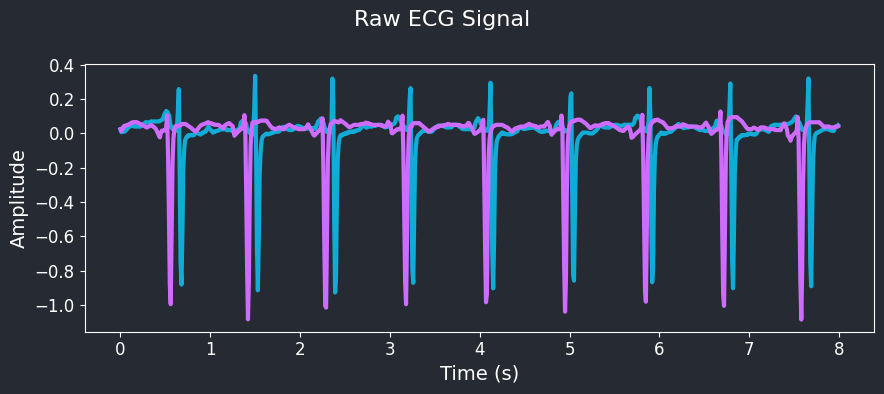

In [9]:
ecg1, ecg2 = next(iter(train_ds))
ecg1, ecg2 = ecg1.numpy().squeeze(), ecg2.numpy().squeeze()

ts = np.arange(0, len(ecg1)) / sampling_rate
fig, ax = plt.subplots(1, 1, figsize=(9, 4))
ax.plot(ts, ecg1, color=plot_theme.primary_color, lw=3)
ax.plot(ts, ecg2, color=plot_theme.secondary_color, lw=3)
fig.suptitle("Raw ECG Signal")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Amplitude")
fig.tight_layout()
fig.show()


## Create augmentation pipeline

To enable self-supervised training to learn useful features from raw ECG signals, we need to create an augmentation pipeline. Each sample will be augmented into two different ways. Using contrastive learning, the model should generate features that are similar for the same sample and different for different samples. 

In [10]:
nstdb = hk.datasets.nstdb.NstdbNoise(target_rate=sampling_rate)
noises = np.hstack((nstdb.get_noise(noise_type="bw"), nstdb.get_noise(noise_type="ma"), nstdb.get_noise(noise_type="em")))
noises = noises.astype(np.float32)

preprocessor = nse.layers.preprocessing.LayerNormalization1D(
    epsilon=epsilon,
    name="LayerNormalization"
)

augmenter = nse.layers.preprocessing.AugmentationPipeline(
    layers=[
        nse.layers.preprocessing.RandomNoiseDistortion1D(
            sample_rate=sampling_rate,
            amplitude=(0, 1.0),
            frequency=(0.5, 1.5),
            name="BaselineWander"
        ),
        nse.layers.preprocessing.RandomSineWave(
            sample_rate=sampling_rate,
            amplitude=(0, 0.05),
            frequency=(45, 50),
            name="PowerlineNoise"
        ),
        nse.layers.preprocessing.AmplitudeWarp(
            sample_rate=sampling_rate,
            amplitude=(0.9, 1.1),
            frequency=(0.5, 1.5),
            name="AmplitudeWarp"
        ),
        nse.layers.preprocessing.RandomGaussianNoise1D(
            factor=(0.05, 0.2),
            name="GaussianNoise"
        ),
        nse.layers.preprocessing.RandomBackgroundNoises1D(
            noises=noises,
            amplitude=(0.05, 0.2),
            num_noises=2,
            name="RandomBackgroundNoises"
        ),
        nse.layers.preprocessing.RandomCutout1D(
            factor=(0.01, 0.05),
            cutouts=2,
            fill_mode="constant",
            fill_value=0.0,
            name="RandomCutout"
        ),
        nse.layers.preprocessing.RandomCrop1D(
            duration=frame_size,
            name="RandomCrop",
            auto_vectorize=True
        )
    ],
)

## Visualize augmented pair

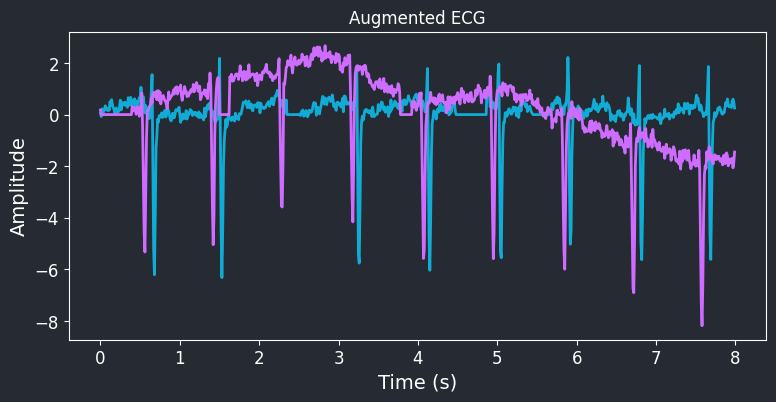

In [11]:
aug_ecg1 = augmenter(preprocessor(keras.ops.convert_to_tensor(np.reshape(ecg1, (1, -1, 1)))), training=True)
aug_ecg1 = aug_ecg1.numpy().squeeze()

aug_ecg2 = augmenter(preprocessor(keras.ops.convert_to_tensor(np.reshape(ecg2, (1, -1, 1)))), training=True)
aug_ecg2 = aug_ecg2.numpy().squeeze()


ts = np.arange(0, frame_size, 1) / sampling_rate

fig, ax = plt.subplots(1, 1, figsize=(9, 4))
plt.title("Augmented ECG")
plt.plot(ts, aug_ecg1, color=plot_theme.primary_color, lw=2)
plt.plot(ts, aug_ecg2, color=plot_theme.secondary_color, lw=2)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Amplitude")
plt.show()

## Create full data pipeline w/ augmentation

We will now create a full data pipeline by extended the original with shuffling, batching, augmentations, and prefetching.

For validation, we will cache a subset of the validation data to speed up the evaluation process.

In [12]:
train_ds = train_ds.shuffle(
    buffer_size=buffer_size,
    reshuffle_each_iteration=True,
).batch(
    batch_size=batch_size,
    drop_remainder=True,
    num_parallel_calls=tf.data.AUTOTUNE,
).map(
    lambda x1, x2: {
        nse.trainers.SimCLRTrainer.SAMPLES: x1,
        nse.trainers.SimCLRTrainer.AUG_SAMPLES_0: augmenter(preprocessor(x1), training=True),
        nse.trainers.SimCLRTrainer.AUG_SAMPLES_1: augmenter(preprocessor(x2), training=True),
    },
    num_parallel_calls=tf.data.AUTOTUNE
).prefetch(
    tf.data.AUTOTUNE
)

val_ds = val_ds.batch(
    batch_size=batch_size,
    drop_remainder=True,
    num_parallel_calls=tf.data.AUTOTUNE,
).map(
    lambda x1, x2: {
        nse.trainers.SimCLRTrainer.SAMPLES: x1,
        nse.trainers.SimCLRTrainer.AUG_SAMPLES_0: augmenter(preprocessor(x1), training=True),
        nse.trainers.SimCLRTrainer.AUG_SAMPLES_1: augmenter(preprocessor(x2), training=True),
    },
    num_parallel_calls=tf.data.AUTOTUNE
).prefetch(
    tf.data.AUTOTUNE
)

# Cache the validation dataset
val_ds = val_ds.take(val_size//batch_size).cache()

## Define encoder model 

For this task, we are going to leverage a customized __EfficientNetV2__ model architecture for the encoder that is smaller and can handle 1D signals. The model consists of 5 main MBConv blocks with a global average pooling layer and a dense layer for classification.

In [13]:
inputs = keras.Input(shape=(frame_size, 1), name="input")

encoder_params=dict(
    input_filters=24,
    input_kernel_size=(1, 9),
    input_strides=(1, 2),
    blocks=[
        dict(filters=32, depth=2, kernel_size=(1, 9), strides=(1, 2), ex_ratio=1, se_ratio=4, norm="layer"),
        dict(filters=48, depth=2, kernel_size=(1, 9), strides=(1, 2), ex_ratio=1, se_ratio=4, norm="layer"),
        dict(filters=64, depth=2, kernel_size=(1, 9), strides=(1, 2), ex_ratio=1, se_ratio=4, norm="layer"),
        dict(filters=80, depth=1, kernel_size=(1, 9), strides=(1, 2), ex_ratio=1, se_ratio=4, norm="layer"),
        dict(filters=96, depth=1, kernel_size=(1, 9), strides=(1, 2), ex_ratio=1, se_ratio=4, norm="layer"),
    ],
    output_filters=projection_width,
    include_top=True,
)

encoder = nse.models.efficientnet.efficientnetv2_from_object(
    x=inputs,
    params=encoder_params,
    num_classes=None
)


### Visualize the model

Let's view the encoder to understand the architecture better.

In [14]:
encoder.summary(print_fn=logger.info, layer_range=('input', 'dropout_1'))
flops = nse.metrics.flops.get_flops(encoder, batch_size=1, fpath=os.devnull)
logger.info(f"Computation: {flops/1e6:0.2f} MFLOPs")
encoder_output = encoder(inputs)

INFO     Model: "EfficientNetV2"                                                               ]8;id=922879;file:///workspaces/heartkit/.venv/lib/python3.12/site-packages/keras/src/utils/summary_utils.py\summary_utils.py]8;;\:]8;id=790357;file:///workspaces/heartkit/.venv/lib/python3.12/site-packages/keras/src/utils/summary_utils.py#380\380]8;;\
         ┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓                              
         ┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃                              
         ┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩                              
         │ input (InputLayer)  │ (None, 800, 1)    │          0 │ -                 │                              
         ├─────────────────────┼───────────────────┼────────────┼───────────────────┤                              
         │ reshape (Reshape)   │ (None, 1, 800, 1) │          0 │ input[0][0]       │                              
         ├─────────────────────┼───────────────────┼────────────┼───────────────────┤                              
         │ stem.conv (Conv2D)  │ (None, 1, 400,    │        216 │ reshape[0][0]     │                              
         │                     │ 24)               │            │                   │                              
         ├─────────────────────┼───────────────────┼────────────┼───────────────────┤                              
         │ stem.bn             │ (None, 1, 400,    │         96 │ stem.conv[0][0]   │                              
         │ (BatchNormalizatio… │ 24)               │            │                   │                              
         ├─────────────────────┼───────────────────┼────────────┼───────────────────┤                              
         │ stem.act            │ (None, 1, 400,    │          0 │ stem.bn[0][0]     │                              
         │ (Activation)        │ 24)               │            │                   │                              
         ├─────────────────────┼───────────────────┼────────────┼───────────────────┤                              
         │ stage1.mbconv1.dp   │ (None, 1, 400,    │        216 │ stem.act[0][0]    │                              
         │ (DepthwiseConv2D)   │ 24)               │            │                   │                              
         ├─────────────────────┼───────────────────┼────────────┼───────────────────┤                              
         │ stage1.mbconv1.dp.… │ (None, 1, 400,    │         96 │ stage1.mbconv1.d… │                              
         │ (BatchNormalizatio… │ 24)               │            │                   │                              
         ├─────────────────────┼───────────────────┼────────────┼───────────────────┤                              
         │ stage1.mbconv1.dp.… │ (None, 1, 400,    │          0 │ stage1.mbconv1.d… │                              
         │ (Activation)        │ 24)               │            │                   │                              
         ├─────────────────────┼───────────────────┼────────────┼───────────────────┤                              
         │ max_pooling2d       │ (None, 1, 200,    │          0 │ stage1.mbconv1.d… │                              
         │ (MaxPooling2D)      │ 24)               │            │                   │                              
         ├─────────────────────┼───────────────────┼────────────┼───────────────────┤                              
         │ stage1.mbconv1.se.… │ (None, 1, 1, 24)  │          0 │ max_pooling2d[0]… │                              
         │ (GlobalAveragePool… │                   │            │                   │                              
         ├─────────────────────┼───────────────────┼────────────┼───────────────────┤                              
         │ stage1.mbconv1.se.… │ (None, 1, 1, 6)

INFO     Computation: 4.17 MFLOPs                                                                    ]8;id=701803;file:///tmp/ipykernel_43488/689369687.py\689369687.py]8;;\:]8;id=782029;file:///tmp/ipykernel_43488/689369687.py#3\3]8;;\

In [15]:
projector_input = encoder_output
projector_output = keras.layers.Dense(projection_width, activation="relu6")(projector_input)
projector_output = keras.layers.Dense(projection_width)(projector_output)
projector = keras.Model(inputs=projector_input, outputs=projector_output, name="projector")
flops = nse.metrics.flops.get_flops(projector, batch_size=1, fpath=os.devnull)
projector.summary(print_fn=logger.info)
logger.debug(f"Projector requires {flops/1e6:0.2f} MFLOPS")

INFO     Model: "projector"                                                                    ]8;id=80169;file:///workspaces/heartkit/.venv/lib/python3.12/site-packages/keras/src/utils/summary_utils.py\summary_utils.py]8;;\:]8;id=604200;file:///workspaces/heartkit/.venv/lib/python3.12/site-packages/keras/src/utils/summary_utils.py#380\380]8;;\
         ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓                              
         ┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃                              
         ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩                              
         │ keras_tensor_108CLONE           │ (None, 128)            │             0 │                              
         │ (InputLayer)                    │                        │               │                              
         ├─────────────────────────────────┼────────────────────────┼───────────────┤                              
         │ dense (Dense)                   │ (None, 128)            │        16,512 │                              
         ├─────────────────────────────────┼────────────────────────┼───────────────┤                              
         │ dense_1 (Dense)                 │ (None, 128)            │        16,512 │                              
         └─────────────────────────────────┴────────────────────────┴───────────────┘                              
          Total params: 33,024 (129.00 KB)                                                                         
          Trainable params: 33,024 (129.00 KB)                                                                     
          Non-trainable params: 0 (0.00 B)                                                                         
                                                                                                                   

## Create a SimCLR model to train

In [16]:
model = nse.trainers.SimCLRTrainer(
    encoder=encoder,
    augmenter=None,  # We augment in the data pipeline
    projector=projector,
)

## Compile the model

We will compile the model using Adam optimizer with cosine learning rate scheduler and custom cosine similarity loss function. We will also attach metrics and callbacks to monitor the training process.


In [17]:
def get_scheduler():
    return keras.optimizers.schedules.CosineDecay(
        initial_learning_rate=learning_rate,
        decay_steps=steps_per_epoch * epochs,
    )

optimizer = keras.optimizers.Adam(get_scheduler())
loss = nse.losses.simclr.SimCLRLoss(temperature=temperature)

metrics = [
    keras.metrics.MeanSquaredError(name="mse"),
    keras.metrics.CosineSimilarity(name="cos"),
]

model_callbacks = [
    keras.callbacks.EarlyStopping(
        monitor=f"val_{val_metric}",
        patience=max(int(0.25 * epochs), 1),
        mode=val_mode,
        restore_best_weights=True,
        verbose=verbose - 1
    ),
    keras.callbacks.ModelCheckpoint(
        filepath=str(model_file),
        monitor=f"val_{val_metric}",
        save_best_only=True,
        mode=val_mode,
        verbose=verbose - 1
    ),
    keras.callbacks.CSVLogger(job_dir / "history.csv"),
]
if nse.utils.env_flag("TENSORBOARD"):
    model_callbacks.append(
        keras.callbacks.TensorBoard(
            log_dir=job_dir,
            write_steps_per_second=True,
        )
    )

model.compile(
    encoder_optimizer=optimizer,
    encoder_loss=loss,
    encoder_metrics=metrics,
)


## Train the model

In [18]:
history = model.fit(
    train_ds,
    steps_per_epoch=steps_per_epoch,
    verbose=verbose,
    epochs=epochs,
    validation_data=val_ds,
    callbacks=model_callbacks,
)

Epoch 1/150


2024-08-14 16:43:57.885843: E tensorflow/core/util/util.cc:131] oneDNN supports DT_INT32 only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.
I0000 00:00:1723653847.481601   43638 service.cc:146] XLA service 0x72a96c0040a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1723653847.481621   43638 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9


 1/25 ━━━━━━━━━━━━━━━━━━━━ 13:38 34s/step - cos: 0.5873 - loss: 15.6832 - mse: 0.2619

I0000 00:00:1723653871.429351   43638 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


25/25 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step - cos: 0.6079 - loss: 14.7544 - mse: 0.2572 - val_cos: 0.6789 - val_loss: 12.3536 - val_mse: 0.2902
Epoch 2/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 218ms/step - cos: 0.6985 - loss: 12.0094 - mse: 0.2832 - val_cos: 0.7271 - val_loss: 11.2826 - val_mse: 0.2748
Epoch 3/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 186ms/step - cos: 0.7307 - loss: 11.0921 - mse: 0.2751 - val_cos: 0.7381 - val_loss: 10.5437 - val_mse: 0.2747
Epoch 4/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 185ms/step - cos: 0.7414 - loss: 10.3584 - mse: 0.2735 - val_cos: 0.7466 - val_loss: 9.9348 - val_mse: 0.2739
Epoch 5/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 183ms/step - cos: 0.7485 - loss: 9.8257 - mse: 0.2716 - val_cos: 0.7494 - val_loss: 9.5416 - val_mse: 0.2717
Epoch 6/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 182ms/step - cos: 0.7507 - loss: 9.4662 - mse: 0.2699 - val_cos: 0.7525 - val_loss: 9.2581 - val_mse: 0.2706
Epoch 7/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 177ms/step - cos: 0.7522 - loss: 9.1834 - mse: 0.2683 - val

### Visualize training history

Let's visualize the training history to understand the model's performance during training. This will help to ensure the model is learning and not under or overfitting.

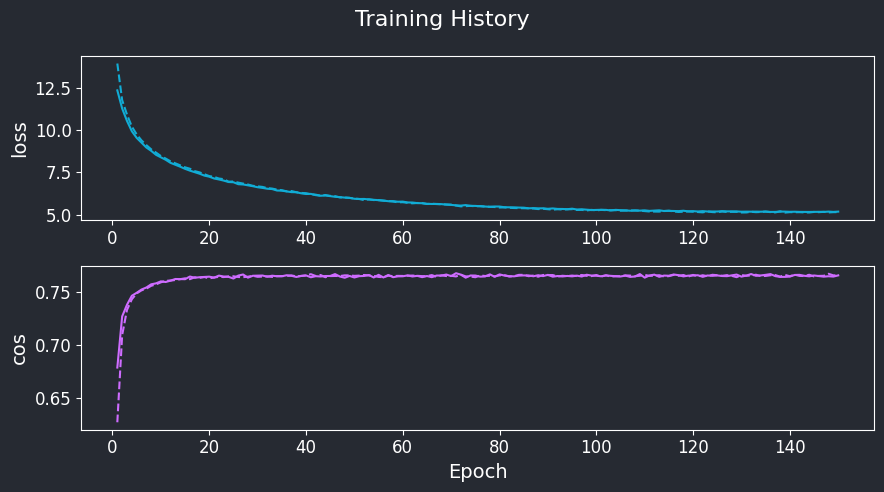

In [19]:
fig, _ = nse.plotting.plot_history_metrics(
    history.history,
    metrics=["loss", "cos"],
    title="Training History",
    colors=[plot_theme.primary_color, plot_theme.secondary_color],
    stack=True,
    figsize=(9, 5),
)
fig.tight_layout()
fig.show()

## Model evaluation

Now that we have trained the model, we will evaluate the model on the test dataset. The model's built-in `evaluate` method will be used to calculate the loss and metrics on the dataset.

In [20]:
# Convert validation dataset to numpy arrays
test_x1, test_x2 = [], []
for inputs in val_ds.as_numpy_iterator():
    test_x1.append(inputs[nse.trainers.SimCLRTrainer.AUG_SAMPLES_0])
    test_x2.append(inputs[nse.trainers.SimCLRTrainer.AUG_SAMPLES_1])
test_x1 = np.concatenate(test_x1)
test_x2 = np.concatenate(test_x2)

In [21]:
test_y1 = encoder.predict(test_x1)
test_y2 = encoder.predict(test_x2)

288/288 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [22]:
rst = nse.metrics.compute_metrics(metrics, test_y1, test_y2)
logger.info("[VAL SET] " + ", ".join([f"{k.upper()}={v:.4f}" for k, v in rst.items()]))

INFO     [VAL SET] MSE=0.0202, COS=0.9626                                                           ]8;id=131897;file:///tmp/ipykernel_43488/4122487501.py\4122487501.py]8;;\:]8;id=360226;file:///tmp/ipykernel_43488/4122487501.py#2\2]8;;\

## Export model to TF Lite / TFLM

Once we have trained and evaluated the model, we need to export the model into a format that can be used for inference on the edge. Currently, we export the model to TensorFlow Lite flatbuffer format. This will also generate a C header file that can be used with TensorFlow Lite for Microcontrollers (TFLM).

For this model, we will export as a 32-bit floating point model.
 
__NOTE:__ We utilize `CONCRETE` mode to lower the model to concrete functions before converting. This is because TF (MLIR) fails to properly lower the dilated convolutional layers.

In [23]:
converter = nse.converters.tflite.TfLiteKerasConverter(model=encoder)

# Redirect stdout and stderr to devnull since TFLite converter is very verbose
with open(os.devnull, 'w') as devnull:
    with contextlib.redirect_stdout(devnull), contextlib.redirect_stderr(devnull):
        tflite_content = converter.convert(
            test_x=test_x1,
            quantization="FP32",
            io_type="float32",
            mode="KERAS",
            strict=False,
            verbose=verbose
        )

W0000 00:00:1723654589.802947   43488 tf_tfl_flatbuffer_helpers.cc:392] Ignored output_format.
W0000 00:00:1723654589.802958   43488 tf_tfl_flatbuffer_helpers.cc:395] Ignored drop_control_dependency.


### Save TFLite model as both a file and C header

In [24]:
converter.export(
    tflite_path=job_dir / "model.tflite"
)

converter.export_header(
    header_path=job_dir / "model.h",
    name="model",
)


### Evaluate TFLite model against TensorFlow model

We will instantiate a tflite interpreter and evaluate the model on the test dataset. This will help us ensure that the model has been exported correctly and is ready for deployment.

In [25]:
tflite = nse.interpreters.tflite.TfLiteKerasInterpreter(tflite_content)
tflite.compile()

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [26]:
converter = nse.converters.tflite.TfLiteKerasConverter(model=encoder)

tflite_content = converter.convert(
    test_x=test_x1,
    quantization="FP32",
    io_type="float32",
    mode="KERAS",
    strict=False,
    verbose=verbose
)


Saved artifact at '/tmp/tmpha_srwfb'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 800, 1), dtype=tf.float32, name='input')
Output Type:
  TensorSpec(shape=(None, 128), dtype=tf.float32, name=None)
Captures:
  126079060503120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  126079060505232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  126079060505616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  126079060505424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  126079060505040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  126079060493328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  126079060506000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  126079043553232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  126079060499856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  126079060493520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  126079043555728: TensorS

W0000 00:00:1723654591.708606   43488 tf_tfl_flatbuffer_helpers.cc:392] Ignored output_format.
W0000 00:00:1723654591.708617   43488 tf_tfl_flatbuffer_helpers.cc:395] Ignored drop_control_dependency.


In [27]:
tflite = nse.interpreters.tflite.TfLiteKerasInterpreter(tflite_content)
tflite.compile()

In [28]:
y1_pred_tf = encoder.predict(test_x1)
y2_pred_tf = encoder.predict(test_x2)

y1_pred_tfl = tflite.predict(x=test_x1)
y2_pred_tfl = tflite.predict(x=test_x2)

288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [29]:
tf_rst = nse.metrics.compute_metrics(metrics, y1_pred_tf, y2_pred_tf)
tfl_rst = nse.metrics.compute_metrics(metrics, y1_pred_tfl, y2_pred_tfl)
logger.info("[TF METRICS] " + " ".join([f"{k.upper()}={v:.4f}" for k, v in tf_rst.items()]))
logger.info("[TFL METRICS] " + " ".join([f"{k.upper()}={v:.4f}" for k, v in tfl_rst.items()]))

INFO     [TF METRICS] MSE=0.0202 COS=0.9626                                                         ]8;id=955392;file:///tmp/ipykernel_43488/2850812944.py\2850812944.py]8;;\:]8;id=274114;file:///tmp/ipykernel_43488/2850812944.py#3\3]8;;\

INFO     [TFL METRICS] MSE=0.0202 COS=0.9625                                                        ]8;id=777899;file:///tmp/ipykernel_43488/2850812944.py\2850812944.py]8;;\:]8;id=903182;file:///tmp/ipykernel_43488/2850812944.py#4\4]8;;\

## ECG Foundation Demo

Finally, we will showcase the foundation model by running across lots of patients and plotting via t-SNE to view the embeddings. This will help us understand how the model is clustering the data and if it is learning useful features.

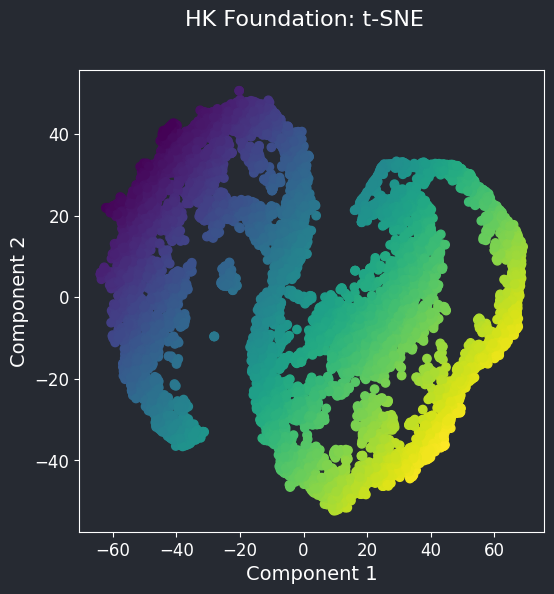

In [30]:
# Compute t-SNE
logger.debug("Computing t-SNE")
tsne = TSNE(n_components=2, random_state=0, n_iter=1000, perplexity=75)
x_tsne = tsne.fit_transform(test_y1)

# Plot t-SNE in matplotlib
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.scatter(x_tsne[:, 0], x_tsne[:, 1], c=x_tsne[:, 0] - x_tsne[:, 1], cmap="viridis")
fig.suptitle("HK Foundation: t-SNE")
ax.set_xlabel("Component 1")
ax.set_ylabel("Component 2")
fig.show()